# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# **Load and Inspect Data**

In [ ]:
file_path = '/content/Customer Data.csv'
data = pd.read_csv(file_path)

In [ ]:
print("First 5 rows of the dataset:")
print(data.head())

First 5 rows of the dataset:
   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season  ...  Payment Method  \
0       Kentucky    L       Gray  Winter  ...           Venmo   
1          Maine    L     Maroon  Winter  ...            Cash   
2  Massachusetts    S     Maroon  Spring  ...     Credit Card   
3   Rhode Island    M     Maroon  Spring  ...          PayPal   
4         Oregon    M  Turquoise  Spring  ...          PayPal   

  Frequency of Purchases                    Random_Date FirstName   LastName  \
0            Fortnightly  2020-

In [ ]:
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Customer ID               0
Age                       0
Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Size                      0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Shipping Type             0
Discount Applied          0
Promo Code Used           0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
Random_Date               0
FirstName                 0
LastName                  0
Email                     0
PhoneNumber               0
TransactionID             0
InteractionID             0
AgentName                 0
dtype: int64


In [ ]:
print("\nSummary statistics:")
print(data.describe())


Summary statistics:
       Customer ID          Age  Purchase Amount (USD)  Review Rating  \
count  3900.000000  3900.000000            3900.000000    3900.000000   
mean   1950.500000    44.068462              59.764359       3.749949   
std    1125.977353    15.207589              23.685392       0.716223   
min       1.000000    18.000000              20.000000       2.500000   
25%     975.750000    31.000000              39.000000       3.100000   
50%    1950.500000    44.000000              60.000000       3.700000   
75%    2925.250000    57.000000              81.000000       4.400000   
max    3900.000000    70.000000             100.000000       5.000000   

       Previous Purchases  TransactionID  InteractionID  
count         3900.000000    3900.000000    3900.000000  
mean            25.351538    1950.500000    2950.500000  
std             14.447125    1125.977353    1125.977353  
min              1.000000       1.000000    1001.000000  
25%             13.000000     9

# **Data Preprocessing**

In [ ]:
def handle_outliers(df, columns, n_sigmas=3):
    """
    معالجة القيم المتطرفة باستخدام z-score
    """
    df_clean = df.copy()
    for col in columns:
        z_scores = stats.zscore(df_clean[col])
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < n_sigmas)
        df_clean = df_clean[filtered_entries]
    return df_clean

In [ ]:
def create_features(df):
    """
    إنشاء متغيرات جديدة
    """
    df_new = df.copy()

    # تحويل Random_Date إلى datetime
    df_new['Random_Date'] = pd.to_datetime(df_new['Random_Date'])
    df_new['Year'] = df_new['Random_Date'].dt.year
    df_new['Month'] = df_new['Random_Date'].dt.month

    # متوسط المشتريات حسب الفئة
    category_avg = df_new.groupby('Category')['Purchase Amount (USD)'].transform('mean')
    df_new['Category_Avg_Purchase'] = category_avg

    # متوسط المشتريات حسب الموسم
    season_avg = df_new.groupby('Season')['Purchase Amount (USD)'].transform('mean')
    df_new['Season_Avg_Purchase'] = season_avg

    # تحويل Frequency of Purchases إلى أرقام
    frequency_map = {
        'Weekly': 52,
        'Fortnightly': 26,
        'Monthly': 12,
        'Quarterly': 4,
        'Annually': 1
    }
    df_new['Purchase_Frequency_Numeric'] = df_new['Frequency of Purchases'].map(frequency_map)

    return df_new

In [ ]:
# معالجة القيم المتطرفة
numeric_cols = ['Age', 'Purchase Amount (USD)', 'Previous Purchases', 'Review Rating']
data_clean = handle_outliers(data, numeric_cols)


In [ ]:
# إنشاء متغيرات جديدة
data_featured = create_features(data_clean)

In [ ]:
# تجهيز البيانات للنمذجة
drop_columns = ['Customer ID', 'FirstName', 'LastName', 'Email', 'PhoneNumber',
                'TransactionID', 'InteractionID', 'Random_Date']
X = data_featured.drop(['Purchase Amount (USD)'] + drop_columns, axis=1)
y = data_featured['Purchase Amount (USD)']

In [ ]:
# تحديد الأعمدة حسب نوعها
categorical_features = ['Category', 'Location', 'Size', 'Color', 'Season',
                       'Subscription Status', 'Shipping Type', 'Frequency of Purchases']
numeric_features = ['Age', 'Previous Purchases', 'Review Rating', 'Year', 'Month']

In [ ]:
# إنشاء معالج البيانات
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first',sparse_output=False), categorical_features)
    ])

In [ ]:
# إنشاء Pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

# **Train and Evaluate Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# تدريب النموذج
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Previous Purchases',
                                                   'Review Rating', 'Year',
                                                   'Month']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Category', 'Location',
                                                   'Size', 'Color', 'Season',
                                                   'Subscription Status',
                                                   'Shipping Type',
                                                   'Frequency of '
                                                   'Purchases'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=200,
                                       random_state=42))])

In [ ]:
# التنبؤ
y_pred = model.predict(X_test)

In [ ]:
# تقييم النموذج
print('R² Score:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: -0.01731706812727718
RMSE: 23.859436243341268


In [ ]:
cv_scores = cross_val_score(model, X, y, cv=5)
print('\nCross-validation scores:', cv_scores)
print('Average CV score:', cv_scores.mean())


Cross-validation scores: [-0.0135926  -0.02091013 -0.01153406 -0.00766164 -0.01511622]
Average CV score: -0.013762930188584344


# **Visualizations**

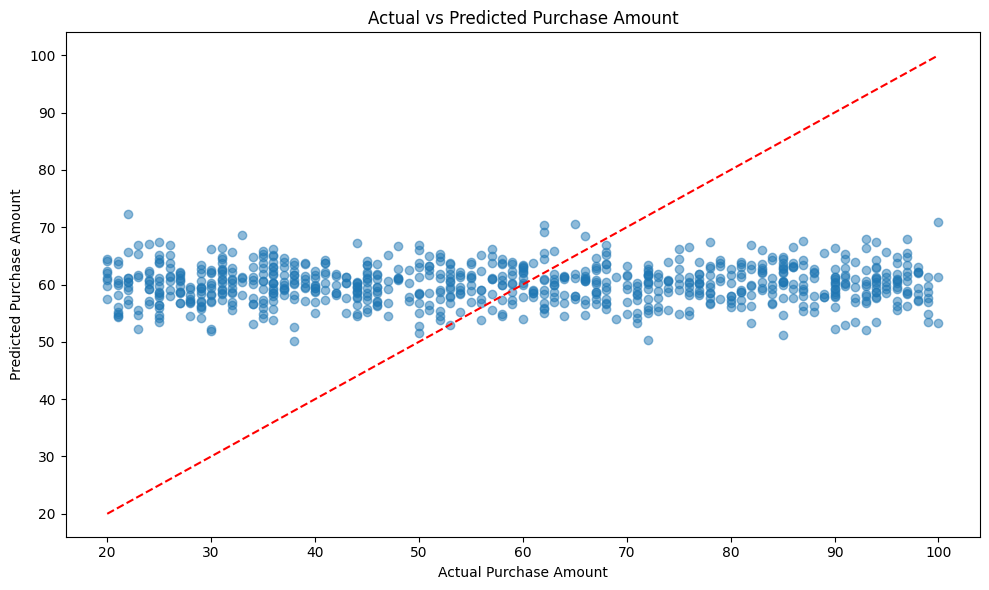

In [ ]:
# 1. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Purchase Amount')
plt.ylabel('Predicted Purchase Amount')
plt.title('Actual vs Predicted Purchase Amount')
plt.tight_layout()
plt.show()

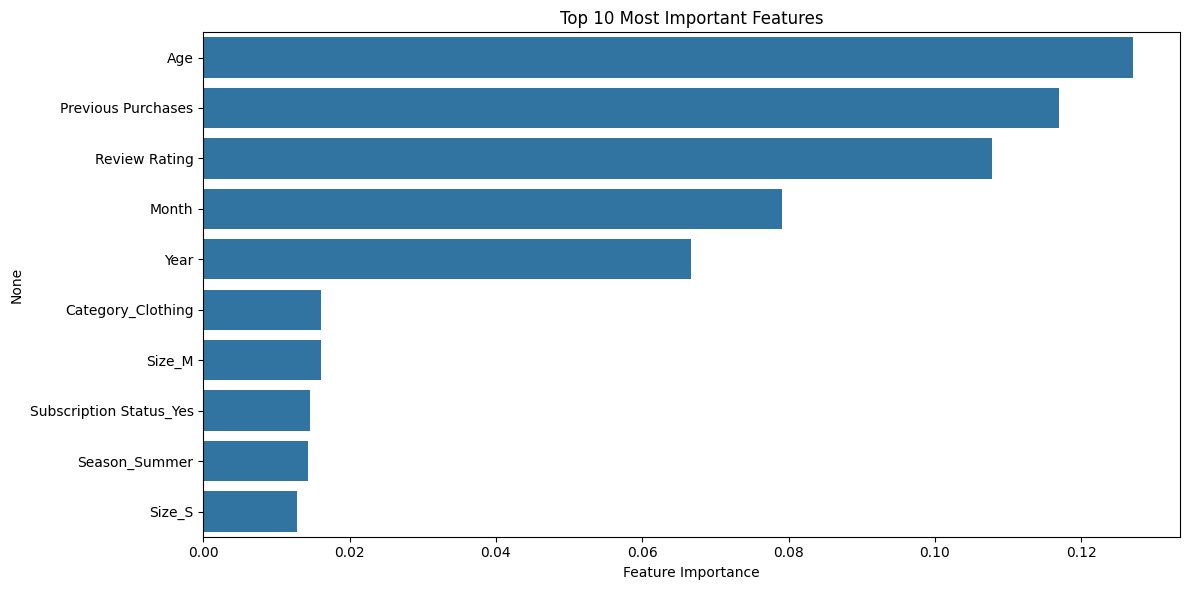

In [ ]:
# 2. Feature Importance Plot
if hasattr(model.named_steps['regressor'], 'feature_importances_'):
    # Get feature names for numeric features
    feature_names = numeric_features

    # Get feature names for categorical features using get_feature_names_out
    # Access the OneHotEncoder within the pipeline
    onehot_encoder = model.named_steps['preprocessor'].named_transformers_['cat']

    # Get categorical feature names
    cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features)

    # Combine numeric and categorical feature names
    feature_names = feature_names + cat_feature_names.tolist()


    importances = pd.DataFrame(
        model.named_steps['regressor'].feature_importances_,
        index=feature_names,
        columns=['importance']
    ).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances['importance'][:10], y=importances.index[:10])
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

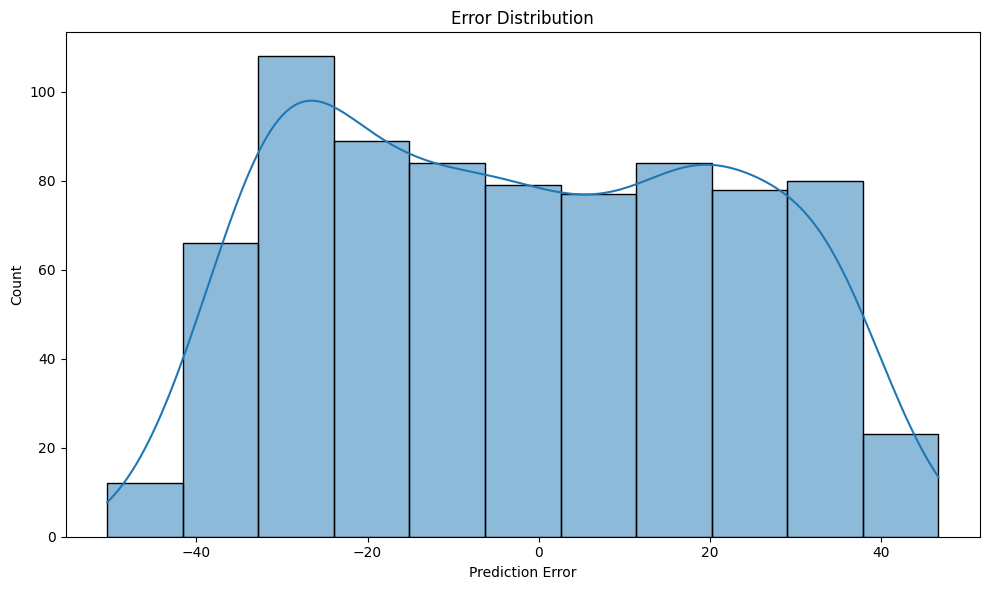

In [ ]:
# 3. Error Distribution Plot
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.tight_layout()
plt.show()

# **Time Series Analysis**

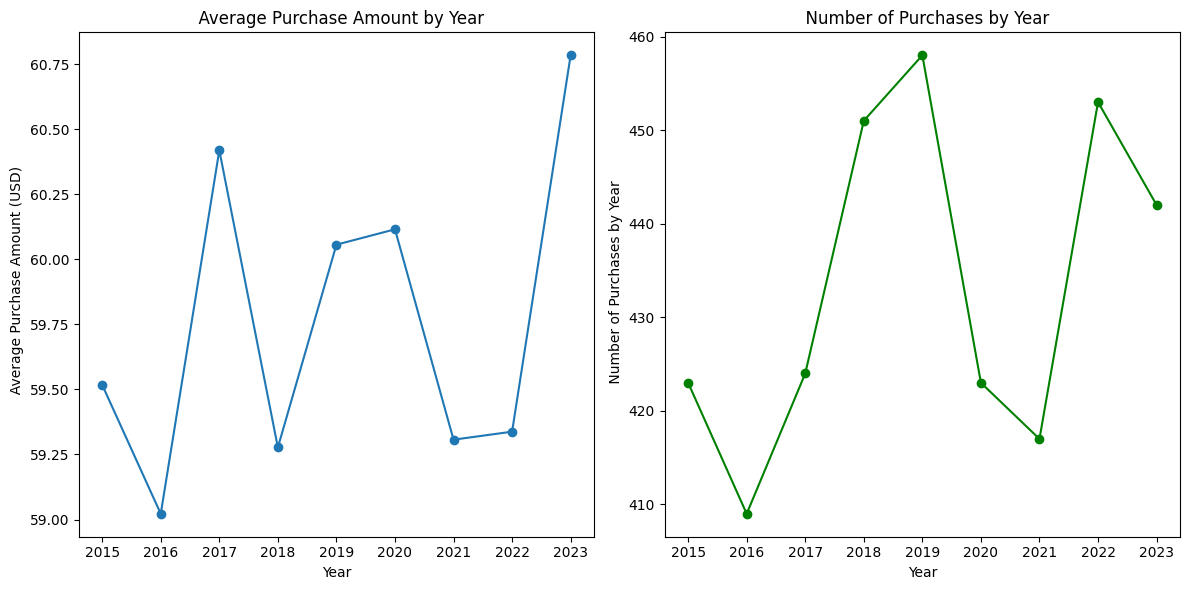

In [ ]:
# تحليل المبيعات عبر الزمن
time_data = data_featured.groupby('Year')['Purchase Amount (USD)'].agg(['mean', 'count'])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(time_data.index, time_data['mean'], marker='o')
plt.title('  Average Purchase Amount by Year')
plt.xlabel('Year')
plt.ylabel('  Average Purchase Amount (USD)')

plt.subplot(1, 2, 2)
plt.plot(time_data.index, time_data['count'], marker='o', color='green')
plt.title('  Number of Purchases by Year')
plt.xlabel('Year')
plt.ylabel(' Number of Purchases by Year')

plt.tight_layout()
plt.show()

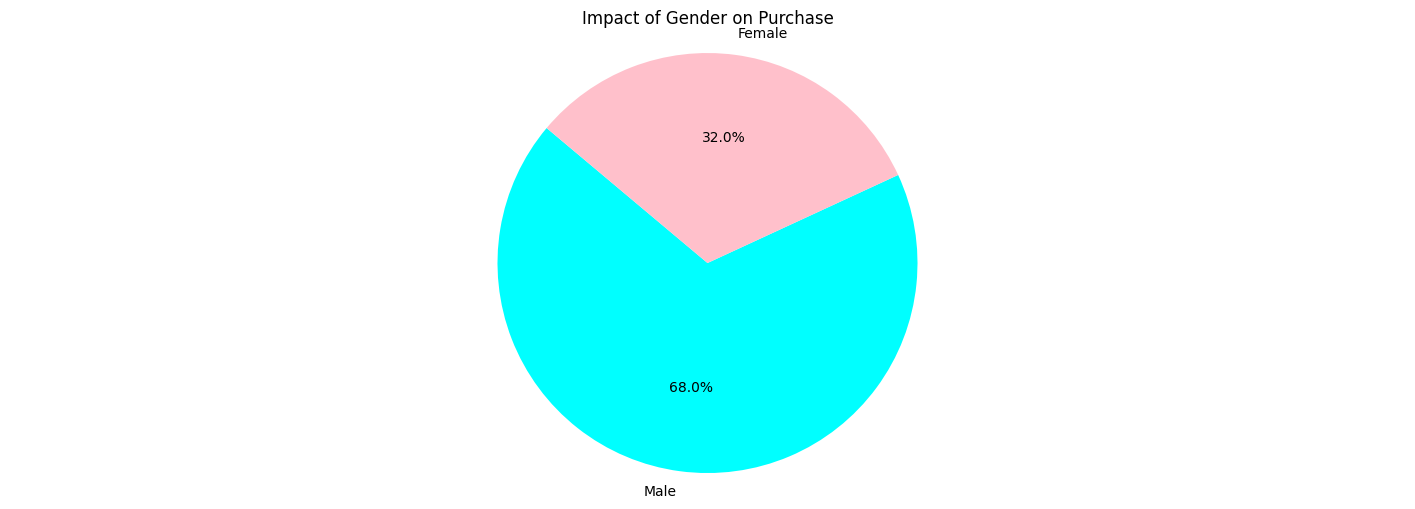

In [ ]:
# Impact of Gender on Purchas
gender_counts_all = data['Gender'].value_counts()

plt.figure(figsize=(18, 6))
plt.pie(gender_counts_all, labels=gender_counts_all.index, autopct='%1.1f%%', colors=['cyan', 'pink'], startangle=140)
plt.title('Impact of Gender on Purchase')
plt.axis('equal')  # Per garantire che il grafico sia un cerchio
plt.show()

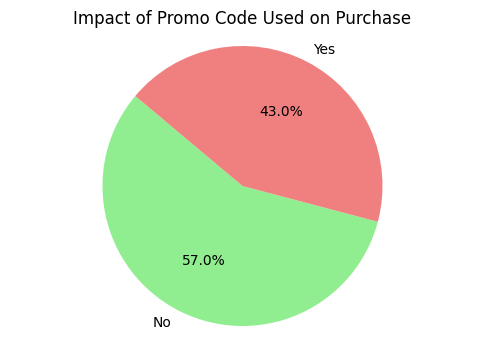

In [ ]:
promo_counts = data['Promo Code Used'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 4))
plt.pie(promo_counts, labels=promo_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'lightcoral'])
plt.title("Impact of Promo Code Used on Purchase")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()